In [ ]:
# 05 – Error Analysis for BERT Fine-tuning

本 notebook 对已经 fine-tune 好的 BERT 模型做系统 **评估 + 错误分析**：

- 从本地加载 finetuned checkpoint（`bert_finetuned.pt`）
- 在验证集上生成预测结果
- 计算 Accuracy / Precision / Recall / F1
- 绘制 Confusion Matrix
- 找出典型错误样本、分析模型不确定度
- 生成一个可导出的 `val_predictions.csv` 供本地进一步分析


In [28]:
import os, sys

# 固定项目根目录（你刚刚确认的那个）
project_root = "/root/AI_support_tickets"
os.chdir(project_root)

print("cwd:", os.getcwd())

# 保证可以 import src.XXX
if project_root not in sys.path:
    sys.path.append(project_root)

# 本地 DistilBERT 目录 & finetuned 模型路径（用绝对路径）
MODEL_DIR = "/root/AI_support_tickets/src/model/distilbert-base-uncased"
BEST_MODEL_PATH = "/root/AI_support_tickets/src/model/bert_finetuned.pt"

print("MODEL_DIR exists:", os.path.isdir(MODEL_DIR))
print("BEST_MODEL_PATH exists:", os.path.isfile(BEST_MODEL_PATH))


cwd: /root/AI_support_tickets
MODEL_DIR exists: True
BEST_MODEL_PATH exists: True


In [29]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

import matplotlib.pyplot as plt

from src.model.bert_model import BertClassifier, get_tokenizer
from src.data_utils import load_text_classification_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [30]:
# 和 04 一样的方式读数据
train_texts, train_labels, label2id, id2label = load_text_classification_data("train")
val_texts, val_labels, _, _ = load_text_classification_data("val")

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print("Label mapping:", label2id)

# 构造 DataFrame，统一列名，后面更好操作
val_df = pd.DataFrame({
    "text": [t.strip() for t in val_texts],
    "label_id": val_labels,
})

TEXT_COL = "text"
LABEL_COL = "label_id"
num_classes = len(id2label)

print("Validation shape:", val_df.shape)
display(val_df.head())


Training samples: 19782
Validation samples: 4239
Label mapping: {'high': 0, 'low': 1, 'medium': 2}
Validation shape: (4239, 2)


,text,label_id
0,Identified Problems with Airtable Synchronizat...,0
1,Problems with Data Integration Using Zapier an...,1
2,Data Access Issue with Cassandra 4.0 SQL Serve...,2
3,Inquiry About API Integration for Project Mana...,2
4,Assistance Required with Analytics Dashboard C...,1


In [31]:
class TicketDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row[TEXT_COL])
        label = int(row[LABEL_COL])

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
            "text": text,
        }


def create_dataloader(df, tokenizer, batch_size=32, shuffle=False):
    dataset = TicketDataset(df, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [32]:
# 1. tokenizer（纯本地）
tokenizer = get_tokenizer(MODEL_DIR)

# 2. DataLoader
val_loader = create_dataloader(val_df, tokenizer, batch_size=32, shuffle=False)

# 3. 初始化模型
model = BertClassifier(
    model_name=MODEL_DIR,
    num_classes=num_classes,
    dropout=0.3,
    freeze_bert=False,
).to(device)

# 4. 加载 finetuned 权重
print("Loading finetuned model from:", BEST_MODEL_PATH)
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
print("Checkpoint keys:", checkpoint.keys())

# 用 checkpoint 中的映射覆盖一下（通常和前面的一致）
label2id = checkpoint.get("label2id", label2id)
id2label = checkpoint.get("id2label", id2label)

# 真正的权重
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()
print("Model loaded and set to eval()")


Loading finetuned model from: /root/AI_support_tickets/src/model/bert_finetuned.pt


/tmp/ipykernel_17894/2010957007.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)


Checkpoint keys: dict_keys(['model_state_dict', 'model_name', 'label2id', 'id2label', 'num_classes'])
Model loaded and set to eval()


In [33]:
all_texts = []
all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        texts = batch["text"]

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=-1)
        preds = probs.argmax(dim=-1)

        all_texts.extend(list(texts))
        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

probs_array = np.array(all_probs)

pred_df = pd.DataFrame({
    "text": all_texts,
    "true_label_id": all_labels,
    "pred_label_id": all_preds,
})

pred_df["true_label"] = pred_df["true_label_id"].map(id2label)
pred_df["pred_label"] = pred_df["pred_label_id"].map(id2label)

for i in range(num_classes):
    pred_df[f"prob_{id2label[i]}"] = probs_array[:, i]

pred_df["max_prob"] = probs_array.max(axis=1)

print("Prediction DataFrame shape:", pred_df.shape)
display(pred_df.head())


Prediction DataFrame shape: (4239, 9)


,text,true_label_id,pred_label_id,true_label,pred_label,prob_high,prob_low,prob_medium,max_prob
0,Identified Problems with Airtable Synchronizat...,0,0,high,high,0.754292,0.000301,0.245407,0.754292
1,Problems with Data Integration Using Zapier an...,1,1,low,low,0.000025,0.999943,0.000032,0.999943
2,Data Access Issue with Cassandra 4.0 SQL Serve...,2,2,medium,medium,0.000277,0.007883,0.991840,0.991840
3,Inquiry About API Integration for Project Mana...,2,2,medium,medium,0.023870,0.014090,0.962040,0.962040
4,Assistance Required with Analytics Dashboard C...,1,2,low,medium,0.000880,0.002719,0.996401,0.996401


In [34]:
pred_df.to_csv("data/val_predictions_for_error_analysis.csv", index=False)
print("Saved to data/val_predictions_for_error_analysis.csv")


Saved to data/val_predictions_for_error_analysis.csv


In [35]:
y_true = pred_df["true_label_id"]
y_pred = pred_df["pred_label_id"]

print("Validation accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[id2label[i] for i in range(num_classes)],
        digits=4,
    )
)


Validation accuracy: 0.752064166076905

Classification report:
              precision    recall  f1-score   support

        high     0.7711    0.7697    0.7704      1615
         low     0.7790    0.6678    0.7191       855
      medium     0.7254    0.7767    0.7502      1769

    accuracy                         0.7521      4239
   macro avg     0.7585    0.7381    0.7466      4239
weighted avg     0.7536    0.7521    0.7516      4239



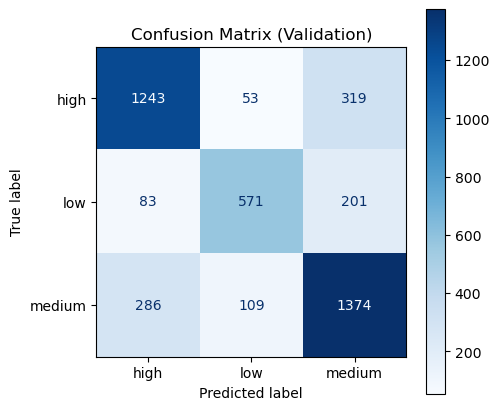

In [36]:
cm = confusion_matrix(y_true, y_pred, labels=list(id2label.keys()))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[id2label[i] for i in range(num_classes)],
)
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()


In [40]:
errors = pred_df[pred_df["true_label_id"] != pred_df["pred_label_id"]].copy()
errors = errors.sort_values(by="max_prob", ascending=False)

print("Total errors:", len(errors))
display(
    errors[
        [
            "text",
            "true_label",
            "pred_label",
            "max_prob",
            "prob_low",
            "prob_medium",
            "prob_high",
        ]
    ].head(20)
)
errors.to_csv("data/val_errors_all.csv", index=False)
print("Saved all error samples to data/val_errors_all.csv")


Total errors: 1051


,text,true_label,pred_label,max_prob,prob_low,prob_medium,prob_high
2495,Urgent Support Inquiry\n\nAn unauthorized acce...,medium,high,0.999953,0.000024,0.000023,0.999953
2232,Inconsistencies Detected in Investment Analyti...,medium,low,0.999951,0.999951,0.000007,0.000042
4165,Support Data Breach\n\nAn incident involving t...,medium,high,0.999951,0.000035,0.000015,0.999951
193,Irregular Connection Problems with Moodle Plat...,high,medium,0.999949,0.000027,0.999949,0.000025
1541,Issue Detected: Underperformance of Digital Ca...,medium,low,0.999947,0.999947,0.000017,0.000036
1446,Problem with Data Analytics Tools\n\nCurrently...,medium,high,0.999943,0.000041,0.000016,0.999943
2718,Problem with Data Analytics Software\n\nWe are...,medium,high,0.999943,0.000030,0.000027,0.999943
4231,Report of System Disruptions\n\nThe team is ex...,medium,high,0.999941,0.000034,0.000026,0.999941
2626,System Performance Improvement\n\nCustomer Sup...,medium,high,0.999939,0.000034,0.000026,0.999939
1914,Support for Software Malfunctions\n\nFacing so...,medium,high,0.999933,0.000058,0.000009,0.999933


Saved all error samples to data/val_errors_all.csv


In [38]:
for label_id, label_name in id2label.items():
    print("=" * 80)
    print(f"True label = {label_name}（模型经常把它错成什么？）")

    subset = errors[errors["true_label_id"] == label_id].head(10)
    display(subset[["text", "true_label", "pred_label", "max_prob"]])


True label = high（模型经常把它错成什么？）


,text,true_label,pred_label,max_prob
193,Irregular Connection Problems with Moodle Plat...,high,medium,0.999949
267,Problems with the Project Management SaaS Plat...,high,medium,0.999922
3393,Problem with Software Stopping\n\nThe software...,high,low,0.999920
2500,Support for SQL Server\n\nIs it possible to ge...,high,medium,0.999917
3224,Problem with Network Connectivity\n\nThe finan...,high,medium,0.999899
2841,Problems Accessing Data in Security Solutions\...,high,medium,0.999894
4135,Support for Kodak ScanMate\n\nIs it possible t...,high,medium,0.999892
2028,Revise Digital Growth Strategy\n\nCustomer sup...,high,medium,0.999869
2706,Strategy for Digital Brand Expansion\n\nCustom...,high,low,0.999861
4174,Problem with Investment Analytics Platform\n\n...,high,medium,0.999843


True label = low（模型经常把它错成什么？）


,text,true_label,pred_label,max_prob
3333,Digital Marketing Strategy Yielding Expected O...,low,medium,0.999911
4109,User Interface Glitch Report\n\nDescription: E...,low,medium,0.999889
237,Problem with Website Speed\n\nThe website is e...,low,medium,0.999884
2321,"Hello Customer Support, I am encountering a sy...",low,medium,0.999876
1963,Concern Regarding the Security of Medical Data...,low,medium,0.999871
1362,Issue Affecting Several Devices\n\nFacing syst...,low,high,0.999870
1211,Issue with Unauthorized Access to Medical Reco...,low,high,0.999863
492,Unexpected Failure of ClickUp Integration Toda...,low,medium,0.999863
67,Report on Misleading Investment Projections\n\...,low,medium,0.999841
2088,Report on Misleading Investment Projections\n\...,low,medium,0.999841


True label = medium（模型经常把它错成什么？）


,text,true_label,pred_label,max_prob
2495,Urgent Support Inquiry\n\nAn unauthorized acce...,medium,high,0.999953
2232,Inconsistencies Detected in Investment Analyti...,medium,low,0.999951
4165,Support Data Breach\n\nAn incident involving t...,medium,high,0.999951
1541,Issue Detected: Underperformance of Digital Ca...,medium,low,0.999947
1446,Problem with Data Analytics Tools\n\nCurrently...,medium,high,0.999943
2718,Problem with Data Analytics Software\n\nWe are...,medium,high,0.999943
4231,Report of System Disruptions\n\nThe team is ex...,medium,high,0.999941
2626,System Performance Improvement\n\nCustomer Sup...,medium,high,0.999939
1914,Support for Software Malfunctions\n\nFacing so...,medium,high,0.999933
1226,Support Request: Issue with Medical Data Trans...,medium,low,0.999928


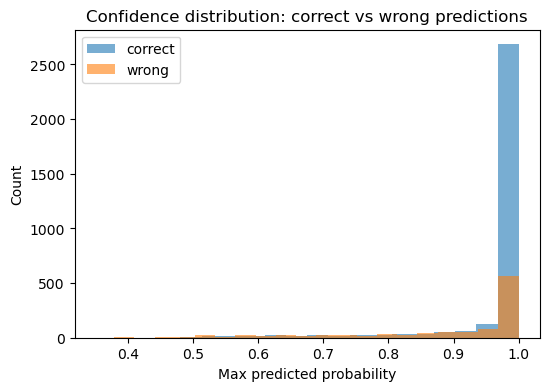

In [39]:
correct = pred_df[pred_df["true_label_id"] == pred_df["pred_label_id"]]
wrong = pred_df[pred_df["true_label_id"] != pred_df["pred_label_id"]]

plt.figure(figsize=(6, 4))
plt.hist(correct["max_prob"], bins=20, alpha=0.6, label="correct")
plt.hist(wrong["max_prob"], bins=20, alpha=0.6, label="wrong")
plt.xlabel("Max predicted probability")
plt.ylabel("Count")
plt.title("Confidence distribution: correct vs wrong predictions")
plt.legend()
plt.show()


## Error Analysis 总结（占位）

可以在这里根据上面的结果写几条 bullet points，例如：

- 整体：验证集 Accuracy ≈ 0.75，macro-F1 ≈ X.X
- 类别表现：`medium` 最好，`low`/`high` 混淆较多（见 Confusion Matrix）
- 常见错误模式：
  - 含有否定/转折/模糊语气的句子
  - 文本极短 / 信息不足
  - 某些样本标注本身存在歧义
- 不确定度：错误样本在 max_prob ∈ [0.4, 0.7] 区间集中，可作为“需人工复审”的候选

这些将来可以直接搬到 README / 报告 / 简历里。
